In [19]:
#@title importing files/data
# File and system handling
import os
import sys

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Suppress warnings
pd.options.mode.chained_assignment = None

# Download NLTK resources
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

# Download and load SpaCy model
!python -m spacy download en_core_web_md
text_to_nlp = spacy.load("en_core_web_md")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [9]:
#@title import our data

# import from Google Cloud
!wget https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%203%20-%20NLP/yelp_final.csv

--2024-12-25 06:29:51--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%203%20-%20NLP/yelp_final.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760976 (743K) [text/csv]
Saving to: ‘yelp_final.csv.3’

yelp_final.csv.3    100%[===================>] 743.14K  --.-KB/s    in 0.005s  

2024-12-25 06:29:51 (149 MB/s) - ‘yelp_final.csv.3’ saved [760976/760976]



# Data Exploration

First we read in the file containing the reviews and take a look at the data available to us.

In [13]:
# read data
yelp_full = pd.read_csv('yelp_final.csv')
yelp_full.head()

,business_id,stars,text,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,_1QQZuf4zZOyFCvXc0o6Vg,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg,1,2,0
3,6ozycU1RpktNG2-1BroVtw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0
4,zp713qNhx8d9KCJJnrw1xA,5,Drop what you're doing and drive here. After I...,wFweIWhv2fREZV_dYkz_1g,7,7,4


In [14]:
# keep the needed columns

needed_columns = ['text', 'stars']
yelp = yelp_full[needed_columns]
yelp.head()

,text,stars
0,My wife took me here on my birthday for breakf...,5
1,I have no idea why some people give bad review...,5
2,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5
3,General Manager Scott Petello is a good egg!!!...,5
4,Drop what you're doing and drive here. After I...,5


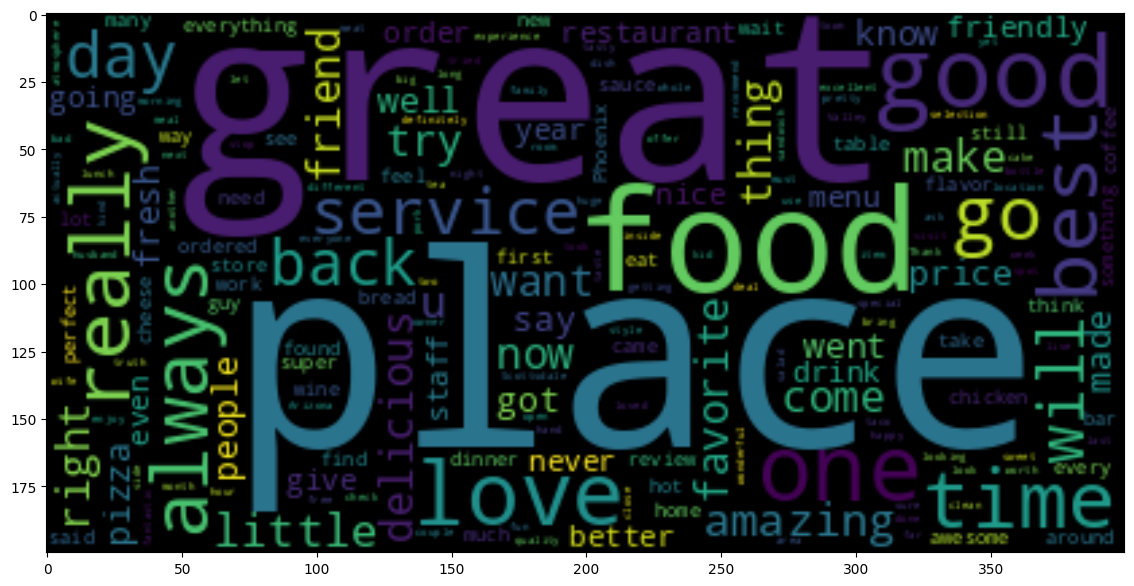

In [18]:
# generate word clouds for differently rated reviews
num_stars =  5
this_star_text = ''
for t in yelp[yelp['stars'] == num_stars]['text'].values:
    this_star_text += t + ' '

wordcloud = WordCloud()
wordcloud.generate_from_text(this_star_text)
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')

##Prepare our data for ML to use logistic regression.

In [21]:
# reduce problem to a binary classification problem

def is_good_review(num_stars):
    if num_stars >= 4: ### YOUR CODE HERE
        return True
    else:
        return False

# Change the stars column to either be 'good' or 'bad'.
yelp['is_good_review'] = yelp['stars'].apply(is_good_review)
yelp.head()

,text,stars,is_good_review
0,My wife took me here on my birthday for breakf...,5,True
1,I have no idea why some people give bad review...,5,True
2,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5,True
3,General Manager Scott Petello is a good egg!!!...,5,True
4,Drop what you're doing and drive here. After I...,5,True


In [22]:
# input x
X_text = yelp['text']
# output y
y = yelp['is_good_review']

In [24]:
def tokenize(text):
    """
    Tokenizes text by removing stop words, punctuation, and pronouns, and returning lemmatized tokens.
    """
    return [
        token.lemma_
        for token in text_to_nlp(text)
        if not token.is_stop and token.lemma_ != '-PRON-' and not token.is_punct
    ]

In [25]:
bow_transformer = CountVectorizer(analyzer=tokenize, max_features=800).fit(X_text)

In [26]:
len(bow_transformer.vocabulary_)

800

In [27]:
# transform each review into a bag of words
X = bow_transformer.transform(X_text)

In [28]:
# see what X looks like by printing it out as a DataFrame
# 1000 reviews and how many times they used each words
pd.DataFrame(X.toarray())

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0,3,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,18,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
996,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,11,0,0,0,0,0,1,0,0,...,2,0,1,0,1,0,1,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##**Logistic Regression** machine learning model.

In [29]:
# setting aside testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [34]:
logistic_model = LogisticRegression()

# train the model

logistic_model.fit(X_train, y_train)

LogisticRegression()

In [35]:
#Enter a review to see your model's classification
example_review = "This place was not good."
prediction = logistic_model.predict(bow_transformer.transform([example_review]))

if prediction:
  print ("This was a GOOD review!")
else:
  print ("This was a BAD review!")



This was a GOOD review!


In [32]:
# test the model

y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.745
